**Loading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
 
%cd gdrive/My Drive/Project
 
import cifar10
 
cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()
 
class_names = cifar10.load_class_names()
images_train, cls_train, labels_train= cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()
 
x_train = images_train[0:45000]
y_train = labels_train[0:45000]
 
 
x_valid = images_train[45000:50000]
y_valid = labels_train[45000:50000]
 
x_test = images_test
y_test = labels_test

Mounted at /content/gdrive
/content/gdrive/My Drive/Project
Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Import Statements**

In [3]:
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Input, Activation, Dropout, AveragePooling2D, Concatenate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Building the Model**

In [ ]:
def dense_block(X, f):
 
  # X_shortcut_0 = X
 
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  X_shortcut_1 = X
 
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 12, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 12, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  X_shortcut_2 = X
 
  X = Concatenate()([X, X_shortcut_1])
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 24, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 24, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  X_shortcut_3 = X
 
  X = Concatenate()([X, X_shortcut_1, X_shortcut_2])
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 36, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 36, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  X_shortcut_4 = X
 
  X = Concatenate()([X, X_shortcut_1, X_shortcut_2, X_shortcut_3])
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 48, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 48, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  X = Concatenate()([X, X_shortcut_1, X_shortcut_2, X_shortcut_3, X_shortcut_4])
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 60, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f + 60, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dropout(0.2)(X)
 
  return X

In [ ]:
def transition_block(X, f):
 
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f, (1,1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
  X = AveragePooling2D((2,2))(X)
 
  return X

In [ ]:
def DenseNet():
 
  X_input = Input((32,32,3))
 
  X = Conv2D(24, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X_input)
 
  X = dense_block(X, 24)
  X = transition_block(X, 84)
 
  X = dense_block(X, 84)
  X = transition_block(X, 144)
 
  X = dense_block(X, 144)
  X = transition_block(X, 204)
 
  X = dense_block(X, 204)
  
  X = AveragePooling2D((4,4))(X)
  X = Flatten()(X)
  X = Dense(10, activation = 'softmax', kernel_initializer = glorot_uniform(seed = 0))(X)
 
  model = Model(inputs = X_input, outputs = X)
 
  return model

In [ ]:
model = DenseNet()
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 32, 32, 24)   672         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_206 (BatchN (None, 32, 32, 24)   96          conv2d_211[0][0]                 
__________________________________________________________________________________________________
activation_206 (Activation)     (None, 32, 32, 24)   0           batch_normalization_206[0][0]    
_______________________________________________________________________________________

**Training the Model**

In [ ]:
model = DenseNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-4), metrics = ['accuracy'])
start = time.time()
model.fit(x_train, y_train, epochs = 1, batch_size = 100, validation_data = (x_valid, y_valid))
end = time.time()

450/450 [==============================] - 98s 218ms/step - loss: 2.1508 - accuracy: 0.1792 - val_loss: 5.1447 - val_accuracy: 0.1018


In [ ]:
model = DenseNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-4), metrics = ['accuracy'])
history = model.fit(x_train, y_train,epochs = 120, batch_size = 100, validation_data = (x_valid, y_valid))

Epoch 1/120
450/450 [==============================] - 99s 219ms/step - loss: 2.1604 - accuracy: 0.1776 - val_loss: 5.5942 - val_accuracy: 0.0950
Epoch 2/120
450/450 [==============================] - 98s 217ms/step - loss: 1.8728 - accuracy: 0.2802 - val_loss: 4.2562 - val_accuracy: 0.1168
Epoch 3/120
450/450 [==============================] - 98s 217ms/step - loss: 1.7084 - accuracy: 0.3515 - val_loss: 3.7256 - val_accuracy: 0.1784
Epoch 4/120
450/450 [==============================] - 98s 217ms/step - loss: 1.6193 - accuracy: 0.3958 - val_loss: 3.2308 - val_accuracy: 0.2046
Epoch 5/120
450/450 [==============================] - 98s 217ms/step - loss: 1.5348 - accuracy: 0.4297 - val_loss: 3.1863 - val_accuracy: 0.2214
Epoch 6/120
450/450 [==============================] - 98s 217ms/step - loss: 1.4620 - accuracy: 0.4628 - val_loss: 3.3942 - val_accuracy: 0.2306
Epoch 7/120
450/450 [==============================] - 98s 217ms/step - loss: 1.3947 - accuracy: 0.4872 - val_loss: 3.6694 -

**Saving the Model, History and Time**

In [ ]:
model.save('DenseNet.h5')

In [ ]:
np.save('DenseNet_history.npy', history.history)

In [ ]:
with open('DenseNet_time.pkl', 'wb') as f:
    pickle.dump(round(end - start), f)

**Training Analysis**

In [4]:
with open('DenseNet_time.pkl', 'rb') as f: 
    time_loaded = pickle.load(f)
print("Time taken for training (1 epoch): ", time_loaded, "seconds")

Time taken for training (1 epoch):  104 seconds


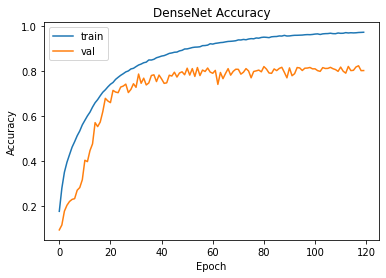

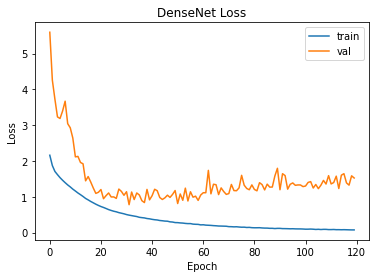

In [5]:
history_loaded = np.load('DenseNet_history.npy', allow_pickle = 'TRUE').item()

plt.plot(history_loaded['accuracy'])
plt.plot(history_loaded['val_accuracy'])
plt.title('DenseNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history_loaded['loss'])
plt.plot(history_loaded['val_loss'])
plt.title('DenseNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing Analysis**

In [6]:
model_loaded = load_model('DenseNet.h5')
y_pred = model_loaded.predict(x_test)

In [7]:
def convert(y):
  return [class_names[np.argmax(i)] for i in y]

y_pred_class = convert(y_pred)
y_true_class = convert(y_test)

********** Accuracy **********

 79.86999999999999 %


********** Classification Report ***********

               precision    recall  f1-score   support

    airplane       0.77      0.81      0.79      1000
  automobile       0.90      0.93      0.91      1000
        bird       0.60      0.88      0.71      1000
         cat       0.78      0.52      0.62      1000
        deer       0.90      0.68      0.77      1000
         dog       0.73      0.74      0.73      1000
        frog       0.94      0.77      0.85      1000
       horse       0.89      0.83      0.86      1000
        ship       0.78      0.92      0.85      1000
       truck       0.84      0.91      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



********** Confusion Matrix ***********




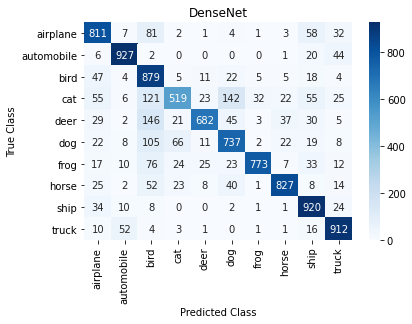

In [11]:
print("********** Accuracy **********\n\n", accuracy_score(y_true_class, y_pred_class) * 100, "%")
print("\n\n********** Classification Report ***********\n\n", classification_report(y_true_class, y_pred_class))
print("\n\n********** Confusion Matrix ***********\n\n")
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('DenseNet')
plt.show()